## Prepare Dataset

In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler

features = ['unix_timestamp', 'open', 'high', 'low', 'close', 'volume'] # full
SEQ_LENGTH = 78  # 5 hours of history (60 * 5min)
START_YEAR = 2019
DATASET_MONTHS = 48
STOCK_NAME = "IBM"

scaler = MinMaxScaler(feature_range=(-1, 1))

def GetDataSetFileName(year, month):
    return f"DataSets/{STOCK_NAME}/{year}/intraday_{year}_{month:02d}_5min_{STOCK_NAME}.csv"

def LoadDataFromFile(filename):
    global X_train, y_train, X_test, y_test, time_step, feature_columns, scaler, scaled_train, scaled_test, df

    raw_csv_data = pd.read_csv(filename)

    raw_csv_data = raw_csv_data[::-1]

    #print(raw_csv_data)

    # Create DataFrame
    df = pd.DataFrame(raw_csv_data, columns=
        features
    )
    df = df.astype(float)

    # Convert the datetime to Unix timestamp (in seconds)
    df['unix_timestamp'] = pd.to_datetime(raw_csv_data['timestamp']).astype('int64') // 10**9

    # Handle missing values
    #df = df.ffill()  # Forward fill missing values

    #print(df.head(5))

    # Create sequences (using 60 time steps to predict next value)
    # Sliding-Window over the dataset, to give ML more context
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data)-seq_length):
            X.append(data[i:(i+seq_length)])
            y.append(data[i+seq_length, [4,5]])
        return np.array(X), np.array(y)

    feature_columns = {features[i] : i for i in range(len(features))}

    # Split data PROPERLY
    split_idx = int(0.8 * len(df))
    train_raw = df.iloc[:split_idx]
    test_raw = df.iloc[split_idx:]

    # Scale using TRAINING DATA ONLY
    scaled_train = scaler.fit_transform(train_raw)
    #scaled_train = scaler.transform(train_raw)
    scaled_test = scaler.transform(test_raw)

    # Create sequences
    X_train, y_train = create_sequences(scaled_train, SEQ_LENGTH)
    X_test, y_test = create_sequences(scaled_test, SEQ_LENGTH)
    #
    time_step = scaled_train[1][0] - scaled_train[0][0]
    #print("time step: ", time_step)

#print("ytest:\n", y_test[0:5])

# Fit the scaler on the entire dataset
# all_data_arr = []
# for i in range(DATASET_MONTHS):
#     raw_csv_data = pd.read_csv(GetDataSetFileName(START_YEAR + i // 12, i % 12 + 1))
#     df = pd.DataFrame(raw_csv_data, columns=features)
#     df = df.astype(float)
#
#     # Convert the datetime to Unix timestamp (in seconds)
#     df['unix_timestamp'] = pd.to_datetime(raw_csv_data['timestamp']).astype('int64') // 10**9
#     all_data_arr.append(df)
#
# # Convert the array with all datasets into one dataset to fit the scaler
# all_data = pd.concat(all_data_arr)
# all_data = all_data[::-1]
# scaler.fit(all_data)

# Load the first batch of data
LoadDataFromFile(GetDataSetFileName(START_YEAR, 1))

# X, y = create_sequences(scaled_all, SEQ_LENGTH)
# Split into train/test
# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]

class StockPredictionDataSet(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        self.X_tensor = torch.Tensor(X_data).to(device)
        self.y_tensor = torch.Tensor(y_data).to(device)

    def load_data(self, X_data, y_data):
        # Clear previous tensors from GPU
        if hasattr(self, 'X_tensor'):
            del self.X_tensor
            del self.y_tensor
        torch.cuda.empty_cache()
        self.X_tensor = torch.Tensor(X_data).to(device)
        self.y_tensor = torch.Tensor(y_data).to(device)

    def __getitem__(self, idx):
        return self.X_tensor[idx], self.y_tensor[idx]
    
    def __len__(self):
        return len(self.X_tensor)

## Prepare LSTM AI

In [2]:
import torch
import torch.nn as nn

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
if torch.cuda.device_count() >= 1:
    print(f"Device name: {torch.cuda.get_device_name(0)}")

print("Is cuda available:", torch.cuda.is_available())  # Should return True
print(torch.version.cuda)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.05
        )
        # self.fc = nn.Linear(hidden_size, 2) # output size
        self.fc_mu = nn.Linear(hidden_size, 2)  # Mean predictions
        self.fc_var = nn.Linear(hidden_size, 2) # Variance
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.SiLU(),
            nn.Linear(128, 2)  # Predict close and direction
        )
        
    # def forward(self, x):
    #     out, _ = self.lstm(x)
    #     out = self.fc(out[:, -1, :])  # Take last time step's output
    #     return out
    def forward(self, x):
            lstm_out, _ = self.lstm(x)
            attn_weights = self.attention(lstm_out)
            context = torch.sum(attn_weights * lstm_out, dim=1)
            return self.fc(context)

# Hyperparameters
model = StockPredictor(
    input_size=len(features),   # (timestamp, open, high, low, close, volume)
    hidden_size=256, # Increases training time
    num_layers=4 # Increases training time
).to(device)

# Optional: Enable cudnn optimizations
# torch.backends.cudnn.benchmark = True

CUDA available: True
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4080
Is cuda available: True
12.6
Using device: cuda


### Prepare Data

In [3]:
from torch.utils.data import DataLoader, TensorDataset

# Initialize train dataset
train_dataset = StockPredictionDataSet(X_train, y_train)

train_loader = DataLoader(
    train_dataset,
    batch_size=1024,  # Adjust based on GPU memory
    shuffle=False,
    num_workers=0,
)

# class VolatilityWeightedLoss(nn.Module): # Custom loss function (Unused)
#     def __init__(self, noise_scale=0.002):
#         super().__init__()
#         self.noise_scale = noise_scale
#
#     def forward(self, inputs, targets):
#         # Calculate volatility weights
#         price_changes = targets[:, 0] - inputs[:, 0]
#         weights = torch.abs(price_changes) # Amplify large moves
#
#         # Weighted MSE
#         mse_loss = torch.mean(weights)
#
#         # Add random noise (adjust noise_scale to taste)
#         #noise = torch.randn(1, device=device) * self.noise_scale
#
#         return mse_loss# + noise


#criterion = VolatilityWeightedLoss() # Loss function

## Training

Switched to DataSets/IBM/2019/intraday_2019_01_5min_IBM.csv at epoch 0
Epoch 10, Loss: 0.1614
Epoch 20, Loss: 0.1394
Switched to DataSets/IBM/2019/intraday_2019_02_5min_IBM.csv at epoch 20
Epoch 30, Loss: 0.0409
Epoch 40, Loss: 0.0216
Switched to DataSets/IBM/2019/intraday_2019_03_5min_IBM.csv at epoch 40
Epoch 50, Loss: 0.0313
Epoch 60, Loss: 0.0279
Switched to DataSets/IBM/2019/intraday_2019_04_5min_IBM.csv at epoch 60
Epoch 70, Loss: 0.0344
Epoch 80, Loss: 0.0315
Switched to DataSets/IBM/2019/intraday_2019_05_5min_IBM.csv at epoch 80
Epoch 90, Loss: 0.0361
Epoch 100, Loss: 0.0310
Switched to DataSets/IBM/2019/intraday_2019_06_5min_IBM.csv at epoch 100
Epoch 110, Loss: 0.0127
Epoch 120, Loss: 0.0108
Switched to DataSets/IBM/2019/intraday_2019_07_5min_IBM.csv at epoch 120
Epoch 130, Loss: 0.0301
Epoch 140, Loss: 0.0264
Switched to DataSets/IBM/2019/intraday_2019_08_5min_IBM.csv at epoch 140
Epoch 150, Loss: 0.0184
Epoch 160, Loss: 0.0165
Switched to DataSets/IBM/2019/intraday_2019_09_

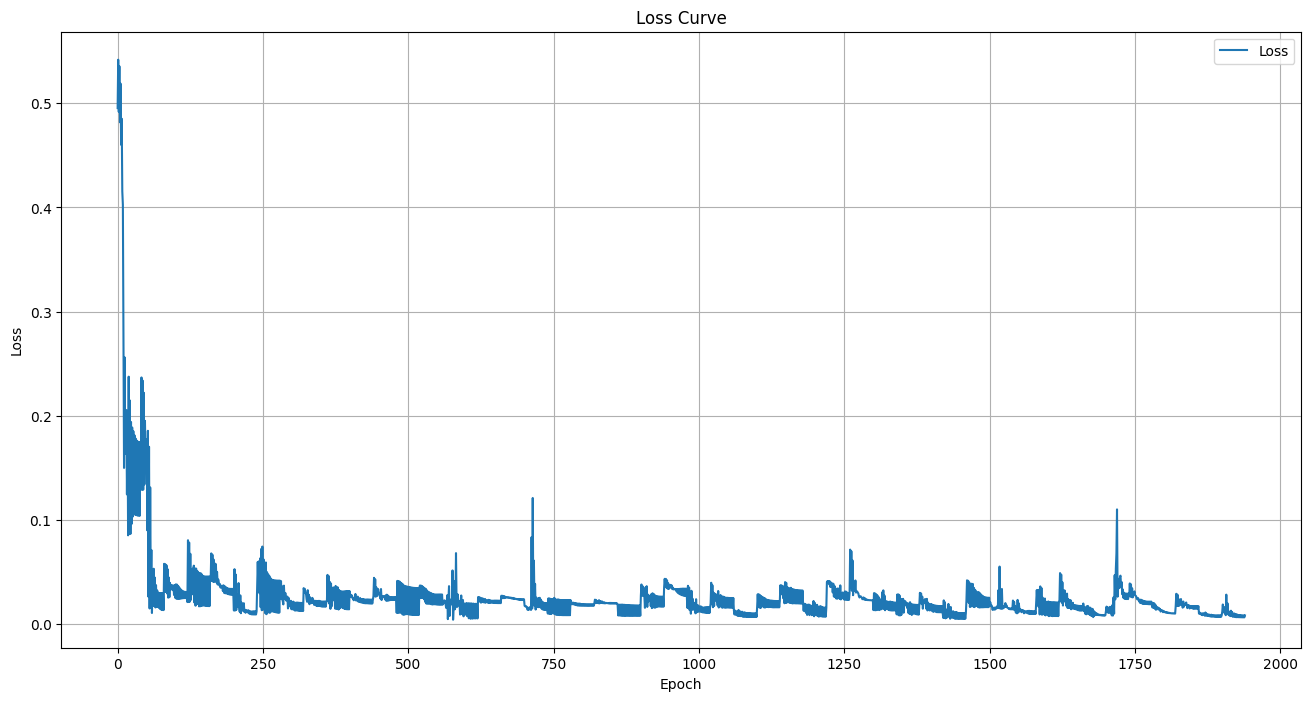

In [4]:
import matplotlib.pyplot as plt

EPOCHS_PER_DATASET = 20
TOTAL_EPOCHS = EPOCHS_PER_DATASET * DATASET_MONTHS

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.0001)
criterion = nn.MSELoss()

# For mixed precision training (optional but recommended)
grad_scaler = torch.amp.GradScaler(device=device)

loss_arr = []

for epoch in range(TOTAL_EPOCHS):  # More epoch -> more trained (takes longer)
    # Dynamic datasets
    if epoch % EPOCHS_PER_DATASET == 0:
        data_idx = epoch // EPOCHS_PER_DATASET
        month = (data_idx % 12 + 1)
        year = data_idx // 12 + START_YEAR
        next_file = GetDataSetFileName(year, month)
        print(f"Switched to {next_file} at epoch {epoch}")
        LoadDataFromFile(next_file)
        train_dataset.load_data(X_train, y_train)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.0005,
            steps_per_epoch=len(train_loader),
            epochs=EPOCHS_PER_DATASET,
            pct_start=0.3
        )

    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.float()
        batch_y = batch_y.float()

        optimizer.zero_grad(set_to_none=True)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        #if not torch.isnan(loss):
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loss_arr.append(loss.item())

        scheduler.step()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

# Plot loss curve
plt.figure(figsize=(16, 8))
plt.plot(loss_arr, label='Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Evaluate

In [5]:
def autoregressive_predict(model, scaler, initial_sequence, true_test_data, feature_columns):
    """
    Simulates real-world prediction without future data access
    - initial_sequence: Last SEQ_LENGTH training samples (scaled)
    - true_test_data: Actual test data for comparison (scaled)
    - feature_columns: Indices of [open, high, low, close, volume]
    """
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for i in range(len(true_test_data)):
        # Predict next close price
        with torch.no_grad():
            inputs = torch.Tensor(current_sequence).unsqueeze(0).to(device)
            pred_scaled = model(inputs).squeeze().cpu().numpy()
            
        # Store prediction
        predictions.append(pred_scaled)
        
        # Create new feature vector (critical!)
        new_features = np.zeros(len(current_sequence[0]))
        
        pred_close_price = pred_scaled[0]
        pred_vol = pred_scaled[1]
        
        # Calculate timestamp (previous timestamp + 5min)
        last_timestamp = current_sequence[-1, feature_columns['unix_timestamp']]
        new_timestamp = last_timestamp + time_step  # 5 minutes in seconds
        new_features[feature_columns['unix_timestamp']] = new_timestamp
        
       # Add realistic noise (0.5% of current price)
        noise_scale = abs(pred_close_price * 0.05)
        pred_close_price += np.random.normal(0, noise_scale)
        
        # Estimated OHLC (using predicted close as all values)
        new_features[feature_columns['open']] = pred_close_price + np.random.normal(0, noise_scale * 0.1)
        new_features[feature_columns['high']] = pred_close_price + np.random.normal(0, noise_scale * 0.1)
        new_features[feature_columns['low']] = pred_close_price + np.random.normal(0, noise_scale * 0.1)
        new_features[feature_columns['close']] = pred_close_price + np.random.normal(0, noise_scale * 0.1)
        
        # Volume handling (set to 0 or average)
        new_features[feature_columns['volume']] = pred_vol  # Or use historical average
        
        # Update sequence (remove oldest, add new prediction)
        current_sequence = np.vstack([current_sequence[1:], new_features])
    
    return predictions

In [6]:
import matplotlib.pyplot as plt
def visualize_predictions(model, scaler, train_data, test_data, seq_length, feature_columns):
    # Get initial sequence (last training samples)
    initial_sequence = train_data[-seq_length:]
    
    #print(initial_sequence[::20])
    
    # Make autoregressive predictions
    test_predictions = np.array(autoregressive_predict(
        model, scaler, initial_sequence, 
        test_data, feature_columns
    ))
    
    #print(test_predictions[::20])
    
    # Inverse scaling for meaningful values
    def inverse_scale(preds, scaler, data_shape):
        dummy = np.zeros((len(preds), data_shape))
        #dummy[:, 0] = preds[:, 0]  # 'timestamp' is at index 0
        dummy[:, feature_columns['close']] = preds[:, 0]  # 'close' is at index 4
        #dummy[:, 5] = preds[:, 1]  # 'vol' is at index 5
        return scaler.inverse_transform(dummy)[:, feature_columns['close']]
    
    # # Inverse scaling
    # def inverse_scale_pred(pred, scaler, feature_columns):
    #     dummy = np.zeros((3, df.shape[1]))
    #     dummy[:, feature_columns['close']] = pred
    #     return scaler.inverse_transform(dummy)[0, feature_columns['close']]
    
    # Convert predictions to actual prices
    pred_prices = inverse_scale(test_predictions, scaler, df.shape[1]) #[inverse_scale_pred(p, scaler, feature_columns) for p in test_predictions]
    true_prices = scaler.inverse_transform(test_data)[:, feature_columns['close']]
    
    # Create timeline
    train_timestamps = df.index[seq_length:len(train_data)]
    test_timestamps = df.index[len(train_data):len(train_data)+len(test_data)]
    
    plt.figure(figsize=(16, 8))
    
    # Plot historical data
    plt.plot(df.index[:len(train_data)], 
             scaler.inverse_transform(train_data)[:, feature_columns['close']], 
             label='Historical Prices', alpha=0.4)
    
    #X_train_timestamps = df.index[seq_length:len(X_train)]
    # Plot training predictions
    train_sequences = torch.Tensor(X_train).to(device)
    with torch.no_grad():
        train_preds = model(train_sequences).squeeze().cpu().numpy()
    #print(train_preds[::20])
    # full_inputs = torch.Tensor(train_data).to(device)
    # train_preds = model(full_inputs).detach().cpu().numpy()
    train_pred_prices = inverse_scale(train_preds, scaler, df.shape[1]) #[inverse_scale_pred(p, scaler, feature_columns) for p in train_preds[seq_length:]]
    #print(train_pred_prices)
    plt.plot(train_timestamps, train_pred_prices, 
             label='Training Fit', linestyle='--')
    
    # Plot test predictions
    plt.plot(test_timestamps, pred_prices, 
             label='Autoregressive Predictions', linewidth=2)
    
    # Plot actual test prices
    plt.plot(test_timestamps, true_prices, 
             label='True Future Prices', alpha=0.7)
    
    plt.axvline(x=test_timestamps[0], color='black', 
                linestyle='--', label='Prediction Start')
    plt.gca().invert_xaxis()
    plt.title('Realistic Stock Price Prediction Performance')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return pred_prices, true_prices

def financial_metrics(true, pred):
    returns_true = np.diff(true) / true[:-1]
    returns_pred = np.diff(pred) / pred[:-1]
    return {
        # Directional Accuracy
        'Direction_Accuracy': np.mean(np.sign(returns_true) == np.sign(returns_pred)),

        # Volatility Capture
        'Volatility_Ratio': np.std(returns_pred) / np.std(returns_true),

        # Risk-Adjusted Returns
        'Sharpe_Ratio': np.mean(returns_pred) / np.std(returns_pred),

        # Maximum Errors
        'Max_Overestimation': np.max(pred - true),
        'Max_Underestimation': np.min(pred - true),

        # Drawdown Simulation
        'Avg_Drawdown_Error': np.mean(
            (np.minimum.accumulate(true) - true) -
            (np.minimum.accumulate(pred) - pred)
        )
    }

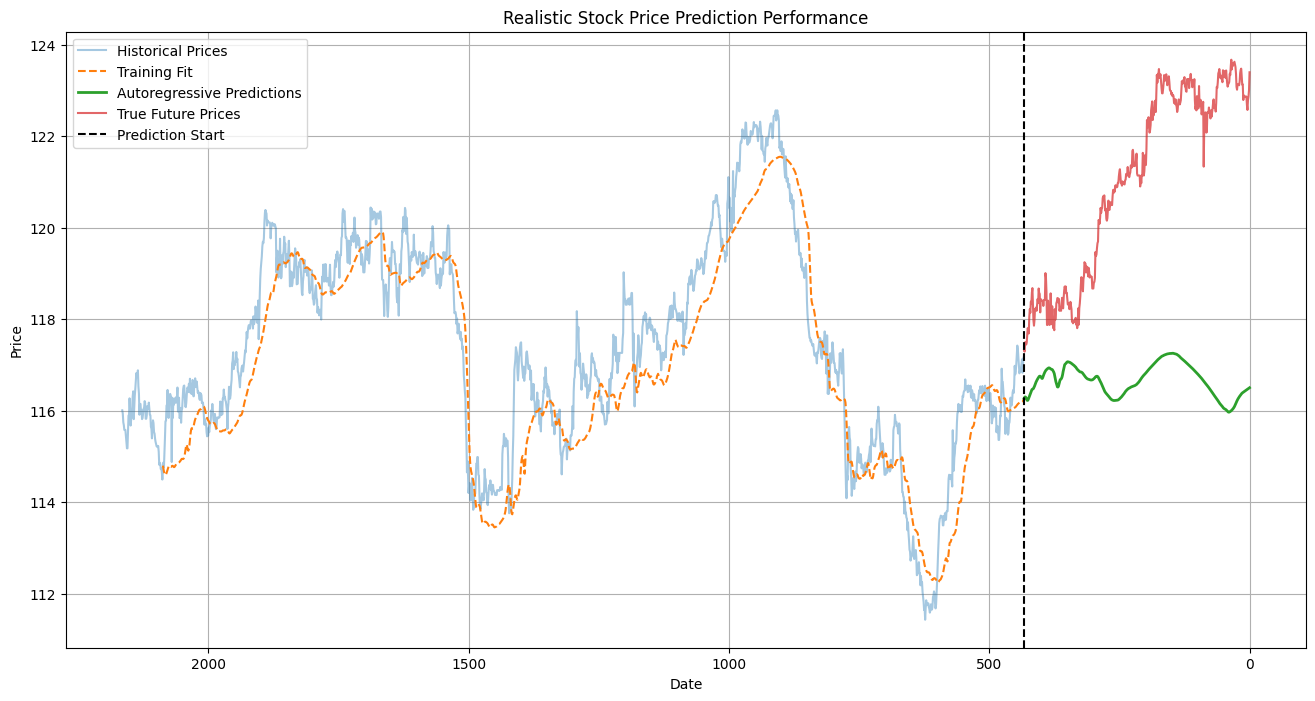


Realistic Performance Report:
- RMSE: 4.83
- MAE: 4.35
- Direction Accuracy: 47.3%


=== Financial Metrics ===
Direction_Accuracy       : 0.4734
Volatility_Ratio         : 0.0900
Sharpe_Ratio             : 0.0330
Max_Overestimation       : -0.8963
Max_Underestimation      : -7.6694
Avg_Drawdown_Error       : -3.2576


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load a different dataset
LoadDataFromFile(GetDataSetFileName(2022, 5))
train_dataset.load_data(X_train, y_train)

# Evaluate properly
model.eval()
pred_prices, true_prices = visualize_predictions(
    model, scaler, scaled_train, scaled_test, 
    SEQ_LENGTH, feature_columns
)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
direction_acc = np.mean(np.diff(true_prices) * np.diff(pred_prices) > 0)

fin_metrics = financial_metrics(true_prices, pred_prices)

print(f"""
Realistic Performance Report:
- RMSE: {rmse:.2f}
- MAE: {mae:.2f}
- Direction Accuracy: {direction_acc*100:.1f}%
""")

# Pretty print results
print("\n=== Financial Metrics ===")
for k, v in fin_metrics.items():
    print(f"{k:<25}: {v:.4f}" if isinstance(v, float) else f"{k:<25}: {v}")